# Geoprocessing
## Lesson Goals

We'll walk through some typical topological operations (spatial subsetting, spatial joins, dissolve) with vector data using using `GeoPandas` - followed by a couple 'real world' spatial tasks.  We'll also incorporate a bit of raster processing such as map algebra, cropping, and zonal statistics.

## Spatial Subsetting
We'll work with gages data from the previous section, and incorporate NHD streamlines, basins and HUC12 data using web services to demonstrate spatial subsetting. We'll demonstrate using the `pynhd` library from Taher's [HyRiver software stack](https://github.com/cheginit/HyRiver-examples) to query the [Network Linked Data Index](https://labs.waterdata.usgs.gov/about-nldi/index.html). 

In [1]:
import pandas as pd
infile = 'Gages_flow_flowdata.csv'
# infile = 'C:/Users/mweber/GitProjects/AWRA2022GeoWorkshop/Workbooks/Python/Session2/Gages_flow_flowdata.csv'
Use_Cols = ['COMID', 'REACHCODE', 'STATE','LON_NHD','LAT_NHD', 'DA_SQ_MILE', 'AVE']
df = pd.read_csv(infile, usecols=Use_Cols,keep_default_na=False, na_values=[''])
df.columns

Index(['COMID', 'REACHCODE', 'STATE', 'DA_SQ_MILE', 'LON_NHD', 'LAT_NHD',
       'AVE'],
      dtype='object')

And again we'll promote our `pandas` dataframe to a `GeoPandas` `GeoDataFrame` as we did in the last section.  Here we'll also use the `explore` method in `GeoPandas` to quickly generate an interactive map of our data, rather than a simple plot with `matplotlib`.

In [2]:
import geopandas as gpd
gages = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LON_NHD, df.LAT_NHD,crs="EPSG:4269"))
gages.explore() 

Gathering the same data we use in our R example follows the example in [HyRiver pynhd nhdplus notebook](https://github.com/cheginit/HyRiver-examples/blob/main/notebooks/nhdplus.ipynb).

In [3]:
import pynhd as nhd
from pynhd import NLDI, NHDPlusHR, WaterData

nldi = NLDI()
station_id = "14187200"

basin = nldi.get_basins(station_id)

In [4]:
SouthSantiam = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamMain",
    source="flowlines")
HUC12_pp = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamTributaries",
    source="huc12pp")

In [5]:
SouthSantiam=SouthSantiam.to_crs(3157)
HUC12_pp=HUC12_pp.to_crs(3157)
gages=gages.to_crs(3157)
basin=basin.to_crs(3157)

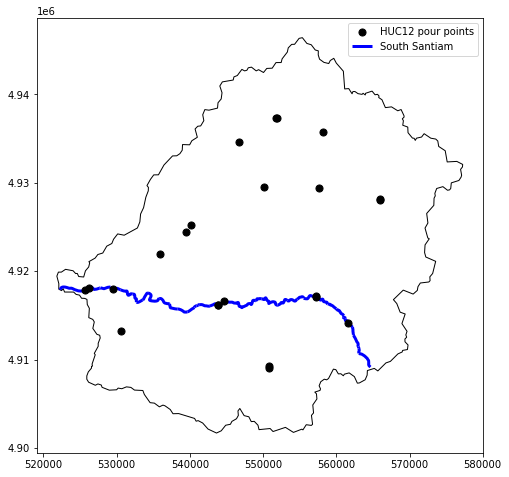

In [24]:
ax = basin.plot(facecolor="none", edgecolor="k", figsize=(8, 8))
HUC12_pp.plot(ax=ax, label="HUC12 pour points", marker="o", markersize=50, color="k", zorder=3)
SouthSantiam.plot(ax=ax, lw=3, color="blue", zorder=2, label="South Santiam")

ax.legend(loc="best")
ax.set_aspect("auto")

In addition to the standard pandas indexing methods, `GeoPanda`s also provides coordinate based indexing with the `cx` indexer, which slices using a bounding box. Geometries in the GeoSeries or GeoDataFrame that intersect the bounding box will be returned similar to what we did in our R example

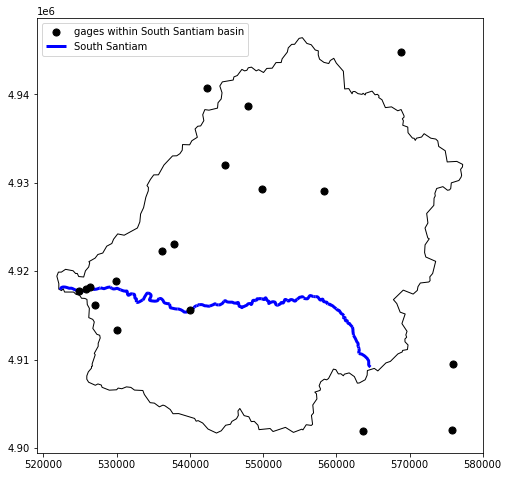

In [6]:
xmin, ymin, xmax, ymax = basin.total_bounds
gages_Santiam = gages.cx[xmin:xmax, ymin:ymax]
ax = basin.plot(facecolor="none", edgecolor="k", figsize=(8, 8))
gages_Santiam.plot(ax=ax, label="gages within South Santiam basin", marker="o", markersize=50, color="k", zorder=3)
SouthSantiam.plot(ax=ax, lw=3, color="blue", zorder=2, label="South Santiam")

ax.legend(loc="best")
ax.set_aspect("auto")

We can also apply a geometry or bounding box fliter as another type of mask on read-in

<AxesSubplot:>

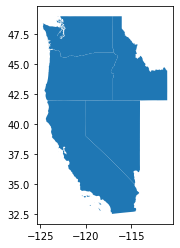

In [13]:
OR_Plus = gpd.read_file('https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json',
    mask=states[states.NAME=="Oregon"],
)
OR_Plus.plot()

Read [the docs](https://geopandas.org/en/stable/docs/user_guide/io.html) - the mask above is actually using a spatial filter and reading in data the *intersects* with our filter criteria (i.e. Oregon).  Using a bounding box.

In [14]:
OR.total_bounds

array([-124.565973,   41.991794, -116.463504,   46.271004])

We can truncate that bounding box and pass it in, or use it as is in the bbox argument to read_file - not that the bbox argument requires a tuple, and the `total_bounds` method returns an array - we need to convert the array to a tuple to use

<AxesSubplot:>

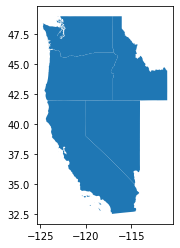

In [15]:
OR_bbox = tuple(OR.total_bounds)
OR = gpd.read_file('https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json',
    bbox=OR_bbox,
)
OR.plot()

In [16]:
bbox = (-122.0, 42.5, -118.0, 45.0)

D:\Anaconda3\envs\StreamCat\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

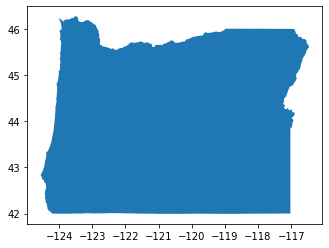

In [63]:
OR = gpd.read_file('https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json',
    bbox=bbox,
)
OR.plot()

#### Read in OpenStreetMap data
`osmnx` is a Python package for working with OpenStreetMap data in Python as either Geopandas Geodataframes or `networkx` network objects - here we do a simple retrieval of all lines designated as 'bike' from OSM for Corvallis as a network object.

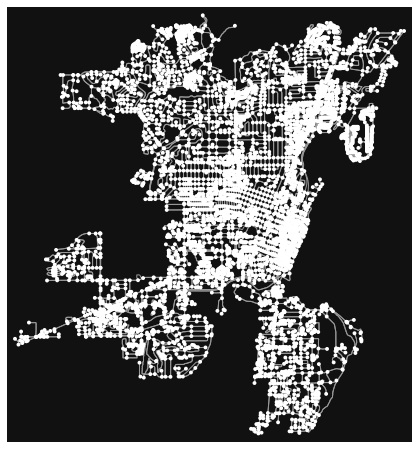

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [17]:
import osmnx as ox
place = ['Corvallis, Oregon, USA',]
G = ox.graph_from_place(place, network_type ="bike")
ox.plot_graph(G)

We can retrieve restarants for Corvallis as well and get some information

In [18]:
# Retrieve restaurants
tags = {"amenity":"restaurant"}
restaurants = ox.geometries_from_place(place, tags)
# How many restaurants do we have?
len(restaurants)

70

See what the `geodataframe` looks like

In [19]:
restaurants.columns
# or
# restaurants.info()

Index(['amenity', 'cuisine', 'name', 'geometry', 'addr:city',
       'addr:housenumber', 'addr:postcode', 'addr:street', 'wheelchair',
       'opening_hours', 'addr:state', 'contact:phone', 'contact:website',
       'diet:vegan', 'diet:vegetarian', 'operator', 'phone', 'email',
       'website', 'fax', 'brand', 'brand:wikidata', 'brand:wikipedia',
       'capacity', 'takeaway', 'delivery', 'addr:unit', 'nodes', 'building',
       'smoking', 'official_name', 'branch', 'source', 'outdoor_seating'],
      dtype='object')

Convert our bike path network to a geodtaframe and plot with restaurants

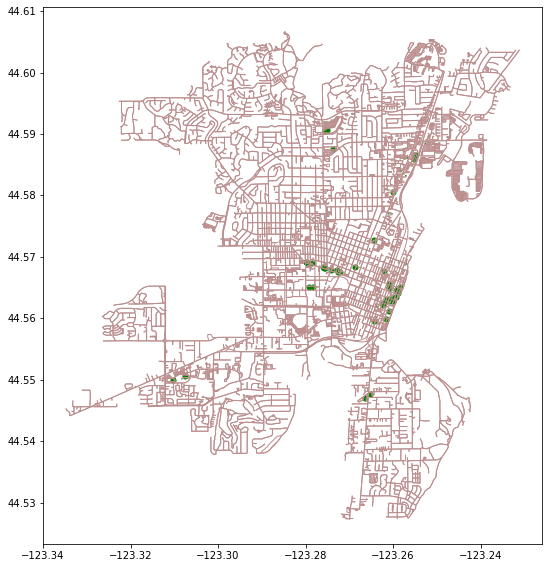

In [20]:
import matplotlib.pyplot as plt
nodes, paths = ox.graph_to_gdfs(G) # this method expects unpacking to a tuple so we need to two obects on left
# paths.head()
fig, ax = plt.subplots(figsize=(12,8))

# Plot restaurants
restaurants.plot(ax=ax, color='green', markersize=26)

# Plot street edges
paths.plot(ax=ax, linewidth=1, edgecolor='#BC8F8F')

plt.tight_layout()

#### Exercise
Based on examples of reading in different datasets and subsetting, try to find a dataset online to read in, or try a different subset operation on example datasets so far, or both.

### Raster Data
For reading and writing raster data in Python we'll use rioxarray in this session, which is based on rasterio package for working with rasters and xarray for working with multi-dimensional arrays - rioxarray basically extends xarray with the rio accessor. There are a lot of ways to work with raster data in Python and we could spend a whole day on it, but this will get us working quickly with raster structures.

We can open datasets using several open methods with rioxarray described [in the docs](https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html) - we will use the `open_rasterio` method.

Here we'll also avoid downloading and using local data by taking advantage of [Cloud-optimized Geotiffs (COGs)](http://www.cogeo.org/) - here we're getting Landsat data from Google Cloud Storage as described in this [great tutorial](https://geohackweek.github.io/raster/04-workingwithrasters/)

In [33]:
import xarray
import rioxarray
filepath = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'
rds = rioxarray.open_rasterio(filepath)
rds

<xarray.DataArray (band: 1, y: 7951, x: 7821)>
[62184771 values with dtype=uint16]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 2.043e+05 2.043e+05 ... 4.389e+05 4.389e+05
  * y            (y) float64 4.268e+06 4.268e+06 4.268e+06 ... 4.03e+06 4.03e+06
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

By default, `xarray` gives us an html representation of the data - this includes information on the dimensions of the array, the list of coordinates, and a list of attributes.  `xarray` make it easy to discover information describing our raster:

In [28]:
rds.spatial_ref

<xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int32 0
Attributes:
    crs_wkt:                           PROJCS["WGS 84 / UTM zone 11N",GEOGCS[...
    semi_major_axis:                   6378137.0
    semi_minor_axis:                   6356752.314245179
    inverse_flattening:                298.257223563
    reference_ellipsoid_name:          WGS 84
    longitude_of_prime_meridian:       0.0
    prime_meridian_name:               Greenwich
    geographic_crs_name:               WGS 84
    horizontal_datum_name:             World Geodetic System 1984
    projected_crs_name:                WGS 84 / UTM zone 11N
    grid_mapping_name:                 transverse_mercator
    latitude_of_projection_origin:     0.0
    longitude_of_central_meridian:     -117.0
    false_easting:                     500000.0
    false_northing:                    0.0
    scale_factor_at_central_meridian:  0.9996
    spatial_ref:                       PROJCS["WGS 84 / UTM zone 11N",GEOGCS[...
    GeoTransform:                      204285.0 30.0 0.0 4268115.0 0.0 -30.0

...Or more succinct coordinate reference system (CRS) information - EPSG codes are a concise way of passing along CRS information - [spatialreference.org](spatialreference.org) is where I typically look up this information

In [29]:
rds.rio.crs

CRS.from_epsg(32611)

In [35]:
rds.dims

('band', 'y', 'x')

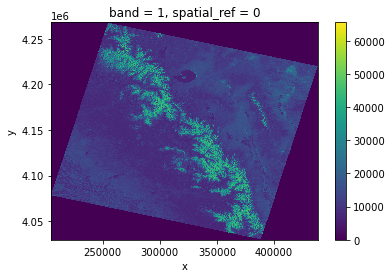

In [36]:
rds.plot()

### Convert flat files to spatial
We often have flat files, locally on our machine or accessed elsewhere, that have coordinate information which we would like to make spatial. 

In the steps below, we 

  1. read in a .csv file of USGS gages in the PNW that have coordinate columns using `read_csv` from `pandas`<br>
      a. Note that we select only certain columns to read in, and that we have to specify '' as NA values - otherwise we get an error from `pandas`<br>
  2. Use `GeoDataFrame` function in `GeoPandas` to convert the data frame to an `GeoDataFRame` - a `pandas` dataframe with a geometry list-column, analagous to our spatial data frame in R<br>
      a. passing the coordinate columns to the gpd.points_from_xy function<br>
      b. specifying a coordinate reference system (CRS)<br>
  4. Plotting our gages as spatial features with `ggplot2` using `geom_sf`.
  
 The [GeoPandas documentation on creating a GeoDataFrame from coordinates](https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html) describes the details.

In [56]:
import pandas as pd
infile = 'E:/GitProjects/AWRA2022GeoWorkshop/Workbooks/Python/Session2/Gages_flow_flowdata.csv'
Use_Cols = ['COMID', 'REACHCODE', 'STATE','LON_NHD','LAT_NHD', 'DA_SQ_MILE', 'AVE']
df = pd.read_csv(infile, usecols=Use_Cols,keep_default_na=False, na_values=[''])
list(df)

['COMID', 'REACHCODE', 'STATE', 'DA_SQ_MILE', 'LON_NHD', 'LAT_NHD', 'AVE']

In [54]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LON_NHD, df.LAT_NHD,crs="EPSG:4269"))

print(gdf.head())

   COMID       REACHCODE STATE  DA_SQ_MILE     LON_NHD    LAT_NHD       AVE  \
0      0  17100308000014    OR      2459.0 -123.318206  42.429592  3402.544   
1      0  17100307000112    OR        52.0 -122.601387  42.425918    60.201   
2      0  17120007000352    OR       170.0 -119.924074  42.425688    34.272   
3      0  17100307000072    OR       138.0 -122.602569  42.407928   104.177   
4      0  17100307000117    OR        43.8 -122.537246  42.402637    72.511   

                      geometry  
0  POINT (-123.31821 42.42959)  
1  POINT (-122.60139 42.42592)  
2  POINT (-119.92407 42.42569)  
3  POINT (-122.60257 42.40793)  
4  POINT (-122.53725 42.40264)  


<AxesSubplot:>

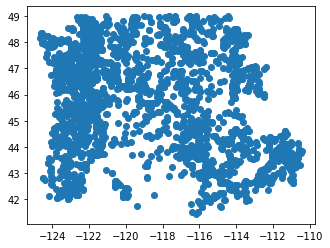

In [55]:
gdf.plot()